Install and load required Python packages

In [ ]:
#@title Installation (Python)

!pip install -U tensorflow-addons

import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from keras.preprocessing import sequence
from keras import backend as K

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.metrics import roc_curve, auc
import sklearn.utils.class_weight as sk_cw

%load_ext tensorboard
%load_ext rpy2.ipython

The R installation might take a few minutes, consider [exporting](https://stackoverflow.com/a/69116838) the installed libraries if you plan to run this notebook more than once.

In [ ]:
%%R
#@title Installation (R)

install.packages("tidymodels")
install.packages("gridExtra")
install.packages("latex2exp")
devtools::install_github('Mikata-Project/ggthemr')

library(tidyverse)
library(tidymodels)
library(grid)
library(gridExtra)
library(ggthemr)
library(latex2exp)

# data_pred is assumed to have the following column:
#  - rating: true class labels
#  - rating_pred: predicted probability of a GOOD rating
metrics_rating_pred <- function(data_pred, ...) {
  
  auc <- data_pred %>%
    mutate(rating_pred = rating_pred) %>%
    roc_auc(truth = rating, rating_pred)
  
  fit_loess <- loess(ratingB ~ rating_pred, 
                   data=(data_pred %>% mutate(ratingB = ifelse(rating == "GOOD", 1, 0))),
                   # Frank Harrell recommends turning off outlier detection in
                   # loess for binary outcomes (Ch2.4)
                   iterations = 1)
  pps <- predict(fit_loess, newdata = data_pred$rating_pred)
  
  ici <- tibble(
    .metric = "ici",
    .estimator = "binary",
    .estimate = mean(abs(pps - data_pred$rating_pred))
  )
  
  emax <- tibble(
    .metric = "Emax",
    .estimator = "binary",
    .estimate = max(abs(pps - data_pred$rating_pred))
  )
  
  N <- length(data_pred$rating_pred)
  base_rate <- sum(data_pred$rating == "GOOD") / length(data_pred$rating_pred)
  resolution <- tibble(
    .metric = "resolution",
    .estimator = "binary",
    .estimate = sum((data_pred$rating_pred - base_rate)^2) / N
  )
  
  bind_rows(
    auc,
    ici,
    emax,
    resolution
  )
  
}

# See metrics_rating_pred function.
# The metrics argument is expected to be the output of metrics_rating_pred.
plot_auc_rating_pred <- function(data_pred, name, metrics, ...) {
  
  auc <- metrics %>%
    filter(.metric == "roc_auc") %>%
    pull(.estimate)
  
  data_pred %>%
    mutate(rating_pred = rating_pred) %>%
    roc_curve(rating, rating_pred) %>%
    ggplot(aes(x = 1 - specificity, y = sensitivity)) +
    geom_path(lwd = 1.5) +
    geom_abline(lty = 3) +
    coord_equal() + 
    theme_minimal() +
    ggtitle(str_interp("${name} - AUC: $[.3f]{auc}"))
  
}

plot_cal_rating_pred <- function(data_pred, name, metrics, ...) {
  
  fit_loess <- loess(ratingB ~ rating_pred,
                     data=(data_pred %>% mutate(ratingB = ifelse(rating == "GOOD", 1, 0))),
                     # Frank Harrell recommends turning off outlier detection in
                     # loess for binary outcomes (Ch2.4)
                     iterations = 1)
  
  ici <- metrics %>%
    filter(.metric == "ici") %>%
    pull(.estimate)
  
  emax <- metrics %>%
    filter(.metric == "Emax") %>%
    pull(.estimate)
  
  # calibration plot
  g1 <- data_pred %>%
    ggplot(aes(x = rating_pred, y = predict(fit_loess))) +
    geom_line(color = "red", lwd=1.5) + 
    scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.1)) +
    scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.1)) +
    geom_abline() + # 45 degree line indicating perfect calibration
    xlab("") +
    ylab("Observed Probability") +
    theme_minimal() +
    ggtitle(str_interp("${name} - ICI: $[.3f]{ici}, Emax: $[.3f]{emax}"))

  # distribution plot        
  g2 <- data_pred %>%
    ggplot(aes(x = rating_pred)) +
    geom_histogram(fill = "black", bins = 200) +
    scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.1)) +
    xlab("Predicted Probability") +
    ylab("") +
    theme_minimal() +
    scale_y_continuous(breaks = c(0, 40)) +
    theme(panel.grid.minor = element_blank())
  
  # combine them    
  g <- arrangeGrob(g1, g2, respect = TRUE, heights = c(1, 0.25), ncol = 1)
  grid.newpage()
  grid.draw(g)
  return(g[[3]])
  
}

Load from Github the first preprocessed subsample of the Swift dataset.


In [4]:
# TMP until repo is public
# ref: https://stackoverflow.com/a/62509005

import requests
from io import StringIO

#@markdown Generate a Github token: https://github.com/settings/tokens
github_username='' #@param {type:"string"}
github_token=''  #@param {type:"string"}

github_session = requests.Session()
github_session.auth = (github_username, github_token)

# providing raw url to download csv from github
url_train = 'https://raw.githubusercontent.com/GiacomoRandazzo/memory-models/main/data-swift/1/data_train.csv'
url_test = 'https://raw.githubusercontent.com/GiacomoRandazzo/memory-models/main/data-swift/1/data_test.csv'

download_train = github_session.get(url_train).content
data_train = pd.read_csv(StringIO(download_train.decode('utf-8')))
download_test = github_session.get(url_test).content
data_test = pd.read_csv(StringIO(download_test.decode('utf-8')))

Data is structured in the following way. Each row corresponds to a review and contains:

- `rating` binary rating of the review; 1 if the answer was recalled, 0 if forgotten
- `intervalDays` number of days since the last review or since the student was introduced the card (more details below)
- `idUser` and `idPrompt` identify, respectively, the student and the card

A review history is identified by a card-student pair. Therefore to group the dataset by review histories we can group them simultaneously by `idUser` and `idPrompt`.

`intervalDays` has been computed in previous preprocessing step. In the original dataset reviews were time-stamped. We grouped them by day (starting at 4am instead of midnight) and considered at most one of them per day (with rating set to 0 if any of the reviews in that day was unsuccessful).

In [5]:
data_train.head()

,rating,intervalDays,idUser,idPrompt
0,0,4,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149
1,0,2,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149
2,0,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149
3,1,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149
4,1,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149


In [6]:
data_test.head()

,rating,intervalDays,idUser,idPrompt
0,1,2,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149
1,1,3,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149
2,1,2,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149
3,1,1,49740A64-594D-49D5-A926-CE16E81705B8,1.2.19-001
4,1,6,49740A64-594D-49D5-A926-CE16E81705B8,1.2.19-001


# R-17 memory model


## Prepare train data

In [11]:
data_train['idHistory'] = data_train.groupby(['idUser', 'idPrompt']).ngroup()
data_train

,rating,intervalDays,idUser,idPrompt,idHistory
0,0,4,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149,9777
1,0,2,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149,9777
2,0,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149,9777
3,1,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149,9777
4,1,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149,9777
...,...,...,...,...,...
80411,0,9,9BCB7EBD-EACC-4E5C-8DDC-D4CE53D274D7,2.7.01-123,6245
80412,1,4,9BCB7EBD-EACC-4E5C-8DDC-D4CE53D274D7,2.7.01-123,6245
80413,0,3,9BCB7EBD-EACC-4E5C-8DDC-D4CE53D274D7,2.7.01-123,6245
80414,1,4,9BCB7EBD-EACC-4E5C-8DDC-D4CE53D274D7,2.7.01-123,6245


In [12]:
user = data_train[["idHistory", "idUser"]].groupby("idHistory").first()
x_train_user = user.to_numpy()
print(f'x_train_user shape: {np.shape(x_train_user)}')

card = data_train[["idHistory", "idPrompt"]].groupby("idHistory").first()
x_train_card = card.to_numpy()
print(f'x_train_card shape: {np.shape(x_train_card)}')

x_train_user shape: (10000, 1)
x_train_card shape: (10000, 1)


In [13]:
def fn_numLapses(x):
  return x.assign(lapse=lambda xx: 1 - xx.rating).groupby(["idHistory"])["lapse"].cumsum()

data_train_1 = data_train.assign(numLapses=fn_numLapses)

In [14]:
sequences = data_train_1[["idHistory", "rating", "intervalDays", "numLapses"]]

sequences_wide = sequences.groupby('idHistory').apply(pd.Series.tolist)

np.array([len(x) for x in sequences_wide])
max_history_length = np.array([len(x) for x in sequences_wide]).max()
print(f'Max history length: {max_history_length}')

sequences_wide_np = sequences_wide.to_numpy()

# pad data
value_pad = -1
sequences_wide_np = sequence.pad_sequences(sequences_wide_np, 
                                            maxlen=max_history_length, 
                                            padding="post", 
                                            value=value_pad,
                                            dtype='float32')

# remove idHistory
sequences_wide_np = np.delete(sequences_wide_np, 0, 2)

# x_train_sequences = np.delete(sequences_wide_np, [0, 3], 2)
x_train_sequences = np.delete(sequences_wide_np, [0], 2)
y_train = np.expand_dims(sequences_wide_np[:,:,0], axis=2)

print(f'x_train_sequences shape: {np.shape(x_train_sequences)}; y_train shape: {np.shape(y_train)}')

cnt_success = y_train[y_train > -1].sum()
cnt_total = len(y_train[y_train > -1])
cnt_failure = cnt_total - cnt_success
prop_success = cnt_success / cnt_total
print(f'Sequences training set proportion of successful reviews: {prop_success}')

Max history length: 62
x_train_sequences shape: (10000, 62, 2); y_train shape: (10000, 62, 1)
Sequences training set proportion of successful reviews: 0.7861370871468365


## Prepare test data

In [15]:
data_test['idHistory'] = data_test.groupby(['idUser', 'idPrompt']).ngroup()
data_test

,rating,intervalDays,idUser,idPrompt,idHistory
0,1,2,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149,38
1,1,3,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149,38
2,1,2,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149,38
3,1,1,49740A64-594D-49D5-A926-CE16E81705B8,1.2.19-001,1180
4,1,6,49740A64-594D-49D5-A926-CE16E81705B8,1.2.19-001,1180
...,...,...,...,...,...
40505,1,1,AE480590-CE72-4344-B329-F59010534E0E,2.1.08-014,3516
40506,1,2,AE480590-CE72-4344-B329-F59010534E0E,2.1.08-014,3516
40507,1,3,AE480590-CE72-4344-B329-F59010534E0E,2.1.08-014,3516
40508,1,4,AE480590-CE72-4344-B329-F59010534E0E,2.1.08-014,3516


In [16]:
user = data_test[["idHistory", "idUser"]].groupby("idHistory").first()
x_test_user = user.to_numpy()
print(f'x_test_user shape: {np.shape(x_test_user)}')

card = data_test[["idHistory", "idPrompt"]].groupby("idHistory").first()
x_test_card = card.to_numpy()
print(f'x_test_card shape: {np.shape(x_test_card)}')

x_test_user shape: (5000, 1)
x_test_card shape: (5000, 1)


In [17]:
data_test_1 = data_test.assign(numLapses=fn_numLapses)

In [18]:
sequences = data_test_1[["idHistory", "rating", "intervalDays", "numLapses"]]

sequences_wide = sequences.groupby('idHistory').apply(pd.Series.tolist)
sequences_wide_np = sequences_wide.to_numpy()
sequences_wide_np = sequence.pad_sequences(sequences_wide_np, 
                                            maxlen=max_history_length, 
                                            padding="post", 
                                            value=value_pad,
                                            dtype='float32')
sequences_wide_np = np.delete(sequences_wide_np, 0, 2)

# x_test_sequences = np.delete(sequences_wide_np, [0,3], 2)
x_test_sequences = np.delete(sequences_wide_np, [0], 2)
y_test = np.expand_dims(sequences_wide_np[:,:,0], axis=2)

print(f'x_test_sequences shape: {np.shape(x_test_sequences)}; y_test shape: {np.shape(y_test)}')

x_test_sequences shape: (5000, 62, 2); y_test shape: (5000, 62, 1)


## Define and fit model

In [19]:
np.random.seed(11042022)
tf.keras.utils.set_random_seed(11042022)

In [20]:
class ForgettingCurveV2(layers.Layer):
    def __init__(self, **kwargs):
      super(ForgettingCurveV2, self).__init__(**kwargs)

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or 
        # manipulate it if this layer changes the shape of the input
        return mask
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1, )

    def call(self, inputs):
      input_s, input_ts = tf.split(inputs, [1,-1], axis=-1)

      # Power law
      # psi = tf.constant(np.log([0.9], dtype=np.float32)) / (input_s + tf.constant(1e-6))
      # pr = tf.math.pow(1 + input_ts, psi)
      pr = tf.math.pow(1 + input_ts, -input_s)

      # Exponential
      # pr = tf.math.exp(tf.constant(np.log([0.9], dtype=np.float32)) * input_ts / (input_s + tf.constant(1e-6)))

      return tf.clip_by_value(pr, 0, 1)

    def get_config(self):
      return {}

In [22]:
class R17CellV2(layers.AbstractRNNCell):
    def __init__(self, units_dense, units_hidden_state, output_bias, **kwargs):
      super(R17CellV2, self).__init__(**kwargs)
      self.units_dense = units_dense
      self.units_hidden_state = units_hidden_state
      self.output_bias = output_bias

      self.dense_stability = layers.Dense(1, activation="relu")

      self.forgetting_curve = ForgettingCurveV2()

      self.dense_retrievability_1 = layers.Dense(units_dense, activation="relu")
      self.dense_retrievability_2 = layers.Dense(units_dense, activation="relu")
      self.dense_retrievability_out = layers.Dense(1, bias_initializer=tf.keras.initializers.Constant(self.output_bias), activation="sigmoid")

      self.dense_hidden_1 = layers.Dense(units_dense, activation="relu")
      self.dense_hidden_2 = layers.Dense(units_dense, activation="relu")
      self.dense_hidden_out = layers.Dense(self.units_hidden_state, activation="relu")

    @property
    def state_size(self):
      return self.units_hidden_state

    def build(self, input_shape):
      self.initial_state = tf.Variable(initial_value=tf.zeros(tf.TensorShape(self.state_size)), trainable=True, name="initial_hidden_state")
      self.built = True
      
    # https://r2rt.com/non-zero-initial-states-for-recurrent-neural-networks.html
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
      init_state_size = [batch_size] + [1]
      var = tf.expand_dims(tf.math.maximum(self.initial_state, tf.constant(1e-6)), 0)
      return tf.tile(var, init_state_size)

    def call(self, inputs, states):
      prev_hidden = states[0]
      # [input_ts, inputs_lapses, input_easiness]
      input_ts, inputs_lapses, inputs_easiness = tf.split(inputs, [1, 2, -1], axis=-1)

      prev_stability = self.dense_stability(tf.concat([prev_hidden, inputs_easiness], axis=-1))
      retrievability_e = self.forgetting_curve(tf.concat([prev_stability, input_ts], axis=-1))

      inputs_r = tf.concat([retrievability_e, prev_stability, inputs_easiness], axis=-1)
      retrievability1 = self.dense_retrievability_1(inputs_r)
      retrievability2 = self.dense_retrievability_2(retrievability1)
      retrievability = self.dense_retrievability_out(retrievability2)

      inputs_s = tf.concat([retrievability, prev_stability, inputs_lapses], axis=-1)
      hidden1 = self.dense_hidden_1(inputs_s)
      hidden2 = self.dense_hidden_2(hidden1)
      hidden = self.dense_hidden_out(hidden2)

      return retrievability, [hidden]

    def get_config(self):
      return {"units_dense": self.units_dense, "units_hidden_state": self.units_hidden_state, "output_bias": self.output_bias}


In [23]:
K.clear_session()

units_dense = 8
units_hidden_state = 5

output_bias = np.log([cnt_success/cnt_failure])
print(f'Initial output bias: {output_bias}; cnt_success: {cnt_success}; cnt_failure: {cnt_failure}; cnt_total:{cnt_total}')


inputs_sequences_1 = layers.Input(shape=(max_history_length, 2), name="inputs_sequences_1")
masked_sequences_1 = layers.Masking(mask_value=value_pad, input_shape=(max_history_length, 2))(inputs_sequences_1)

inputs_sequences_2 = layers.Input(shape=(max_history_length, 1), name="inputs_sequences_2")
masked_sequences_2 = layers.Masking(mask_value=value_pad, input_shape=(max_history_length, 1))(inputs_sequences_2)

input_user = layers.Input(shape=(1), name="input_user", dtype="string")
layer_onehot_user = tf.keras.layers.StringLookup(output_mode='one_hot')
layer_onehot_user.adapt(x_train_user)
onehot_user = layer_onehot_user(input_user)

input_card = layers.Input(shape=(1), name="input_card", dtype="string")
layer_onehot_card = tf.keras.layers.StringLookup(output_mode='one_hot')
layer_onehot_card.adapt(x_train_card)
onehot_card = layer_onehot_card(input_card)

categories = layers.concatenate([onehot_user, onehot_card])
easiness = layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-2), name="easiness")(categories)
repeated_easiness = layers.RepeatVector(max_history_length.item())(easiness)


inputs_rnn = layers.concatenate([masked_sequences_1, masked_sequences_2, repeated_easiness])
rnn = layers.RNN(R17CellV2(units_dense, units_hidden_state, output_bias), return_sequences=True, name='rnn')(inputs_rnn)



model_0 = keras.Model(inputs=[inputs_sequences_1, inputs_sequences_2, input_user, input_card], outputs=rnn, name="model_r17")
model_0.summary()

Initial output bias: [1.30179597]; cnt_success: 63218.0; cnt_failure: 17198.0; cnt_total:80416
Model: "model_r17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_user (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 input_card (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1644)         0           ['input_user[0][0]']             
                                                                                                  
 string_lookup_1 (StringLookup)  (None, 1243)        0           ['input_card[0][0]']         

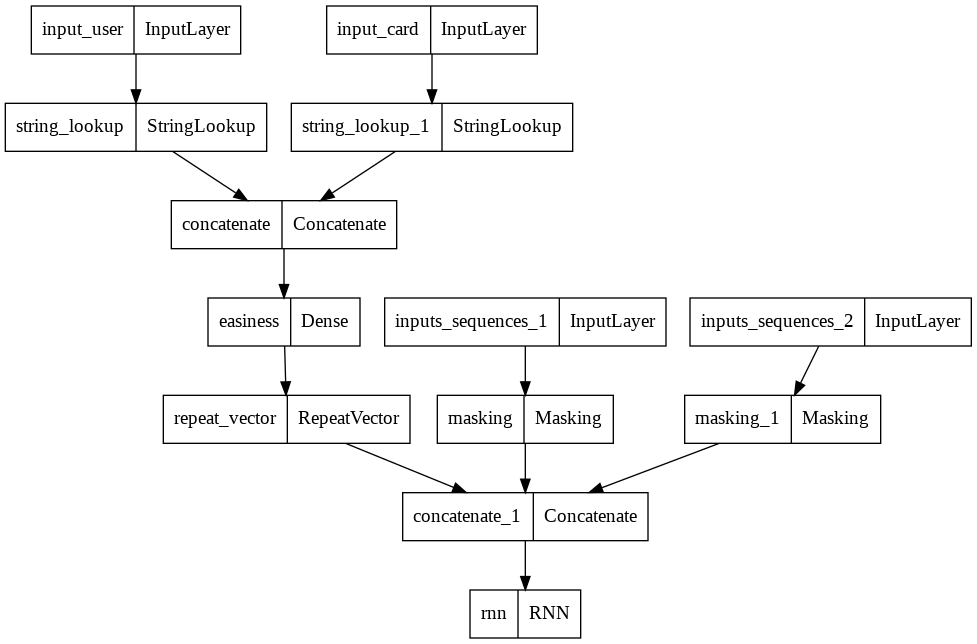

In [24]:
keras.utils.plot_model(model_0)

In [25]:
EPOCHS = 1300
BATCH_SIZE = 128

INIT_LR = 3e-3
MAX_LR = 1e-2

In [26]:
def scale_fn(x):
  return 1/(2.**(x-1))
steps_per_epoch = np.ceil(np.shape(x_train_sequences)[0]/BATCH_SIZE)
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate = INIT_LR,
    maximal_learning_rate = MAX_LR,
    scale_fn = scale_fn,
    step_size = 8 * steps_per_epoch
)

model_0.compile(optimizer = tf.optimizers.Adam(clr, clipnorm=1), # tf.optimizers.Adam(1e-3, clipnorm=1)
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.AUC()]) # ,tf.keras.metrics.BinaryAccuracy()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

In [ ]:
%tensorboard --logdir logs/fit/

In [27]:
results_pre = model_0.evaluate([x_train_sequences, y_train, x_train_user, x_train_card], y_train, batch_size=128, verbose=0)
print("Loss: {:0.4f}".format(results_pre[0]))

Loss: 0.0430


In [28]:
model_0.fit([x_train_sequences, y_train, x_train_user, x_train_card], y_train, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE,
            callbacks=[tensorboard_callback])

Epoch 1/1300
79/79 [==============================] - 8s 57ms/step - loss: 0.0224 - auc: 0.6382
Epoch 2/1300
79/79 [==============================] - 4s 56ms/step - loss: 0.0169 - auc: 0.8199
Epoch 3/1300
79/79 [==============================] - 4s 56ms/step - loss: 0.0165 - auc: 0.8257
Epoch 4/1300
79/79 [==============================] - 4s 56ms/step - loss: 0.0164 - auc: 0.8287
Epoch 5/1300
79/79 [==============================] - 4s 56ms/step - loss: 0.0163 - auc: 0.8312
Epoch 6/1300
79/79 [==============================] - 5s 59ms/step - loss: 0.0163 - auc: 0.8316
Epoch 7/1300
79/79 [==============================] - 4s 55ms/step - loss: 0.0163 - auc: 0.8309
Epoch 8/1300
79/79 [==============================] - 4s 56ms/step - loss: 0.0162 - auc: 0.8320
Epoch 9/1300
79/79 [==============================] - 4s 55ms/step - loss: 0.0163 - auc: 0.8318
Epoch 10/1300
79/79 [==============================] - 4s 55ms/step - loss: 0.0163 - auc: 0.8322
Epoch 11/1300
79/79 [==================

## Evaluation

In [29]:
predictions = model_0.predict([x_test_sequences, y_test, x_test_user, x_test_card])

predictions_r = predictions[y_test > -1].flatten()
y_test_r = y_test[y_test > -1].flatten()

print(f'predictions_r shape: {np.shape(predictions_r)}; y_test_r shape: {np.shape(y_test_r)}')

np_predictions = np.concatenate((np.array(y_test_r).reshape(-1, 1), predictions_r.reshape(-1, 1)), axis=1)
df_predictions = pd.DataFrame(data=np_predictions, columns=["rating", "rating_pred"])
df_predictions.head()

predictions_r shape: (40510,); y_test_r shape: (40510,)


,rating,rating_pred
0,0.0,0.594703
1,0.0,0.443031
2,0.0,0.452367
3,0.0,0.406027
4,1.0,0.373471


In [30]:
%%R -i df_predictions

r_predictions <- df_predictions %>% mutate(rating = factor(ifelse(rating == 1, "GOOD", "AGAIN"), levels = c("GOOD", "AGAIN")))
metrics <- metrics_rating_pred(r_predictions)
metrics

# A tibble: 4 × 3
  .metric    .estimator .estimate
  <chr>      <chr>          <dbl>
1 roc_auc    binary        0.843 
2 ici        binary        0.0140
3 Emax       binary        0.161 
4 resolution binary        0.0393


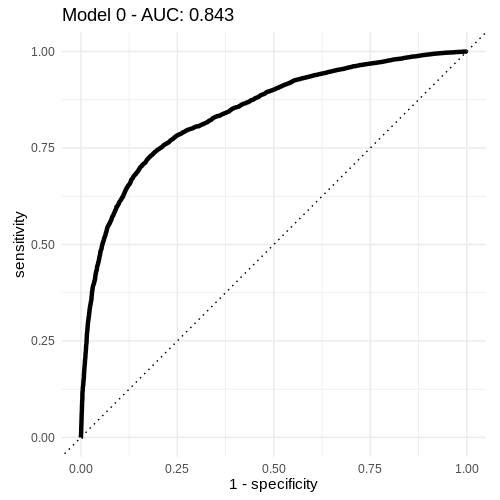

In [31]:
%%R -i df_predictions -w 5 -h 5 --units in -r 100

plot_auc_rating_pred(r_predictions, "Model 0", metrics)

[1] 1null


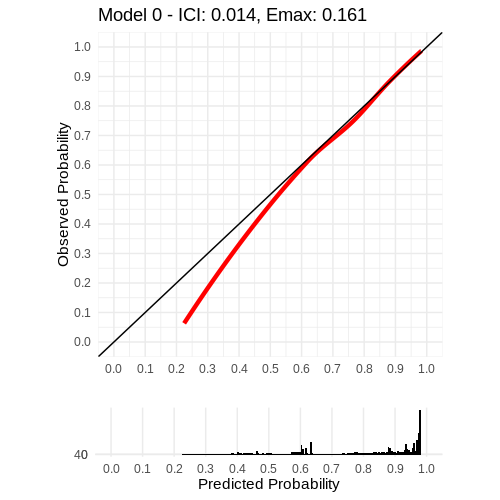

In [32]:
%%R -i df_predictions -w 5 -h 5 --units in -r 100

plot_cal_rating_pred(r_predictions, "Model 0", metrics)

## Model exploration

### Forgetting curves

In [33]:
xs = np.linspace(1., 60., num=1000)

u = "7C0EB3F8-3D9A-42D1-A1B9-2CD762392296"
c = "2.6.06-213"

sequences_11 = sequence.pad_sequences([[ [1.,0,1], [5.,0,1], [x,0,1]] for x in xs], 
                        maxlen=62, 
                        padding="post", 
                        value=-1,
                        dtype='float32')
x_sequences_11 = np.delete(sequences_11, [2], 2)
y_11 = np.expand_dims(sequences_11[:,:,2], axis=2)

sequences_01 = sequence.pad_sequences([[ [1.,1,0], [5.,1,1], [x,1,1]] for x in xs], 
                        maxlen=62, 
                        padding="post", 
                        value=-1,
                        dtype='float32')
x_sequences_01 = np.delete(sequences_01, [2], 2)
y_01 = np.expand_dims(sequences_01[:,:,2], axis=2)

sequences_10 = sequence.pad_sequences([[ [1.,0,1], [5.,1,0], [x,1,1]] for x in xs], 
                        maxlen=62, 
                        padding="post", 
                        value=-1,
                        dtype='float32')
x_sequences_10 = np.delete(sequences_10, [2], 2)
y_10 = np.expand_dims(sequences_10[:,:,2], axis=2)

x_user = np.array([[u] for _ in range(0, 1000)])
x_card = np.array([[c] for _ in range(0, 1000)])

preds_11 = model_0.predict([x_sequences_11, y_11, x_user, x_card])
preds_01 = model_0.predict([x_sequences_01, y_01, x_user, x_card])
preds_10 = model_0.predict([x_sequences_10, y_10, x_user, x_card])

ys_11 = preds_11[:, 2:3, :].flatten()
ys_01 = preds_01[:, 2:3, :].flatten()
ys_10 = preds_10[:, 2:3, :].flatten()

df = pd.DataFrame(np.column_stack((xs, ys_11, ys_01, ys_10)), 
                  columns=["xs", "ys11", "ys01", "ys10"])

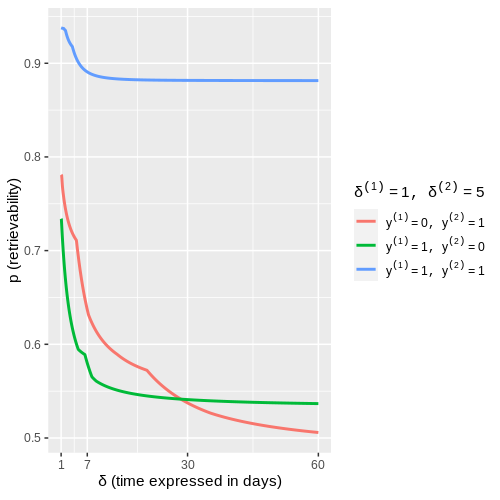

In [34]:
%%R -i df -w 5 -h 5 --units in -r 100

as_tibble(df) %>%
  mutate(
      xs=as.numeric(xs), 
      ys11=as.numeric(ys11),
      ys10=as.numeric(ys10),
      ys01=as.numeric(ys01),
  ) %>%
  pivot_longer(!xs, names_to = "fc", values_to = "ys") %>%
  ggplot(aes(x = xs, y = ys, col=fc)) +
  geom_line(size=1) + 
  scale_x_continuous(breaks=c(1,7,30,60)) + 
  ylab("p (retrievability)") + 
  xlab(TeX("$\\delta$ (time expressed in days)")) +
  labs(col = TeX("$\\delta^{(1)} = 1, \\delta^{(2)} = 5$")) +
  scale_color_discrete(labels = c(TeX("$y^{(1)} = 0, y^{(2)} = 1$"), TeX("$y^{(1)} = 1, y^{(2)} = 0$"), TeX("$y^{(1)} = 1, y^{(2)} = 1$")))

### Approximations of SM-17 functions

In [36]:
layer_rnn = model_0.layers[-1]
layer_rnn.cell.dense_retrievability_1

frozen_easiness = {
    "input_user": model_0.layers[0],
    "input_card": model_0.layers[1],
    "onehot_user": model_0.layers[2],
    "onehot_card": model_0.layers[3],
    "categories": model_0.layers[4],
    "easiness": model_0.layers[7],
}

frozen_p = {
    "p_0": layer_rnn.cell.dense_retrievability_1,
    "p_1": layer_rnn.cell.dense_retrievability_2,
    "p_out": layer_rnn.cell.dense_retrievability_out,
}

frozen_s = {
    "h_0": layer_rnn.cell.dense_hidden_1,
    "h_1": layer_rnn.cell.dense_hidden_2,
    "h_out": layer_rnn.cell.dense_hidden_out,
    "s_out": layer_rnn.cell.dense_stability,
}

Easiness $\sigma_e(c,s)$

In [37]:
input_user = layers.Input(shape=(1), name="input_user", dtype="string")
layer_onehot_user = tf.keras.layers.StringLookup(output_mode='one_hot')
layer_onehot_user.adapt(x_train_user)
onehot_user = layer_onehot_user(input_user)

input_card = layers.Input(shape=(1), name="input_card", dtype="string")
layer_onehot_card = tf.keras.layers.StringLookup(output_mode='one_hot')
layer_onehot_card.adapt(x_train_card)
onehot_card = layer_onehot_card(input_card)

categories = layers.concatenate([onehot_user, onehot_card])
easiness = layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-2), name="easiness")(categories)

model_easiness = keras.Model(inputs=[input_user, input_card], outputs=easiness, name="model_r17_easiness")


model_easiness.layers[0].set_weights(frozen_easiness["input_user"].get_weights())
model_easiness.layers[1].set_weights(frozen_easiness["input_card"].get_weights())
model_easiness.layers[2].set_weights(frozen_easiness["onehot_user"].get_weights())
model_easiness.layers[3].set_weights(frozen_easiness["onehot_card"].get_weights())
model_easiness.layers[4].set_weights(frozen_easiness["categories"].get_weights())
model_easiness.layers[5].set_weights(frozen_easiness["easiness"].get_weights())


x_user = np.array([u])
x_card = np.array([c])

sigma_e = model_easiness.predict([x_user, x_card]).flatten()[0]
print(f"sigma_e: {sigma_e}")

sigma_e: 0.4847681224346161


$Recall$ function

In [40]:
input_p = layers.Input(shape=(3), name="input_p")

d_p_0 = layers.Dense(units_dense, activation="relu")(input_p)
d_p_1 = layers.Dense(units_dense, activation="relu")(d_p_0)
d_p_out = layers.Dense(1, activation="sigmoid")(d_p_1)

model_p = keras.Model(inputs=input_p, outputs=d_p_out, name="model_r17_p")


model_p.layers[1].set_weights(frozen_p["p_0"].get_weights())
model_p.layers[2].set_weights(frozen_p["p_1"].get_weights())
model_p.layers[3].set_weights(frozen_p["p_out"].get_weights())


N_GRID = 30

p_fc = np.linspace(0, 1, N_GRID)
s = np.linspace(0, 6, N_GRID)

P_fc, S = np.meshgrid(p_fc, s)


flattened = np.dstack((P_fc, S)).reshape((-1,2))
x = np.array([np.append(ar, sigma_e) for ar in flattened])

P = model_p.predict(x).reshape((N_GRID,N_GRID))


fig = go.Figure(data=[go.Surface(z=P, x=P_fc, y=S)])
fig.update_layout(title='Recall', autosize=False,
                  width=700, height=700,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene = dict(
                    xaxis_title='p_fc',
                    yaxis_title='psi',
                    zaxis_title='p'),
                  scene_camera = dict(
                    up=dict(x=0, y=0, z=1),
                    center=dict(x=0, y=0, z=0),
                    eye=dict(x=-2.3, y=-0.7, z=0.5)
                  )
)
fig.show()

$S_{Inc}$ function

In [41]:
input_h = layers.Input(shape=(4), name="input_h")

d_h_0 = layers.Dense(units_dense, activation="relu", name="d_h_0")(input_h)
d_h_1 = layers.Dense(units_dense, activation="relu", name="d_h_1")(d_h_0)
d_h_out = layers.Dense(units_hidden_state, activation="relu", name="d_h_out")(d_h_1)

input_easiness = layers.Input(shape=(1), name="input_easiness")

s_out = layers.Dense(1, activation="relu", name="s_out")(tf.concat([d_h_out, input_easiness], axis=-1))

model_s = keras.Model(inputs=[input_h, input_easiness], outputs=s_out, name="model_r17_s")


model_s.layers[1].set_weights(frozen_s["h_0"].get_weights())
model_s.layers[2].set_weights(frozen_s["h_1"].get_weights())
model_s.layers[3].set_weights(frozen_s["h_out"].get_weights())
model_s.layers[6].set_weights(frozen_s["s_out"].get_weights())


N_GRID = 30

p = np.linspace(0, 1, N_GRID)
s_im1 = np.linspace(0, 10, N_GRID)

P, S_im1 = np.meshgrid(p, s_im1)


flattened = np.dstack((P, S_im1)).reshape((-1,2))
x_y1 = np.array([np.append(ar, [0, 1]) for ar in flattened])

x_sigmae = np.array([[sigma_e] for i in range(0, N_GRID*N_GRID)])

S_i = model_s.predict([x_y1, x_sigmae]).reshape((N_GRID,N_GRID))


fig = go.Figure(data=[go.Surface(z=S_i, x=P, y=S_im1)])
fig.update_layout(title='SInc', autosize=False,
                  width=700, height=700,
                  margin=dict(l=40, r=50, b=65, t=90),
                  scene = dict(
                    xaxis_title='p',
                    yaxis_title='psi^(i-1)',
                    zaxis_title='psi^(i)'),
                  scene_camera = dict(
                    up=dict(x=0, y=0, z=1),
                    center=dict(x=0, y=0, z=0),
                    eye=dict(x=-1.5, y=-1.5, z=0.24)
                  )
)
fig.show()

$PLS$ function

In [42]:
N_GRID = 100

p = np.linspace(0, 1, N_GRID)
l = np.linspace(0, 6, N_GRID)

P, L = np.meshgrid(p, l)


flattened = np.dstack((P, L)).reshape((-1,2))
x_y1 = np.array([[ar[0], 5, ar[1], 0] for ar in flattened])

x_sigmae = np.array([[sigma_e] for i in range(0, N_GRID*N_GRID)])

S = model_s.predict([x_y1, x_sigmae]).reshape((N_GRID,N_GRID))


fig = go.Figure(data=[go.Surface(z=S, x=P, y=L)])
fig.update_layout(title='PLS', autosize=False,
                  width=700, height=700,
                  margin=dict(l=40, r=50, b=65, t=90),
                  scene = dict(
                    xaxis_title='p',
                    yaxis_title='l',
                    zaxis_title='psi'),
                  scene_camera = dict(
                    up=dict(x=0, y=0, z=1),
                    center=dict(x=0, y=0, z=0),
                    eye=dict(x=-1.5, y=-1.5, z=0.24)
                  )
)
fig.show()